In [1]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats as stats

import arviz as az
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## Data

In [3]:
import pickle as pk

path = 'drive/MyDrive/DATA/'
file_name = 'data_sharks.pickle'

with open(path+file_name, 'rb') as f:
    data = pk.load(f)

data.keys()

dict_keys(['hammerhead', 'mako', 'tiger_shark', 'great_white', 'megalodon'])

## EDA

In [6]:
outs_len = {key:[len(i) for i in data[key]['outs']] for key in data.keys()}
inps_len = {key:[len(i) for i in data[key]['inputs']] for key in data.keys()}

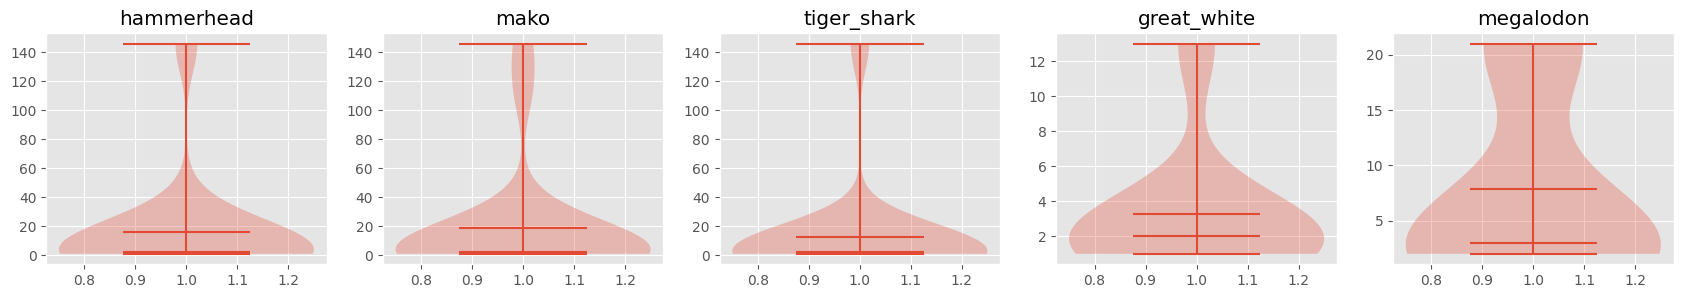

In [15]:
fit, axs = plt.subplots(1, len(outs_len.keys()), figsize=(21, 3))

for i, shark in enumerate(outs_len.keys()):
    axs[i].violinplot(outs_len[shark], showmeans=True, showmedians=True)
    axs[i].set_title(shark)

## Model

In [68]:
outs = np.array([x for xs in list(outs_len.values()) for x in xs])
categories = np.array(list(data.keys()))
idx = pd.Categorical([key for key, val in outs_len.items() for i in val], categories).codes
groups = len(np.unique(idx))

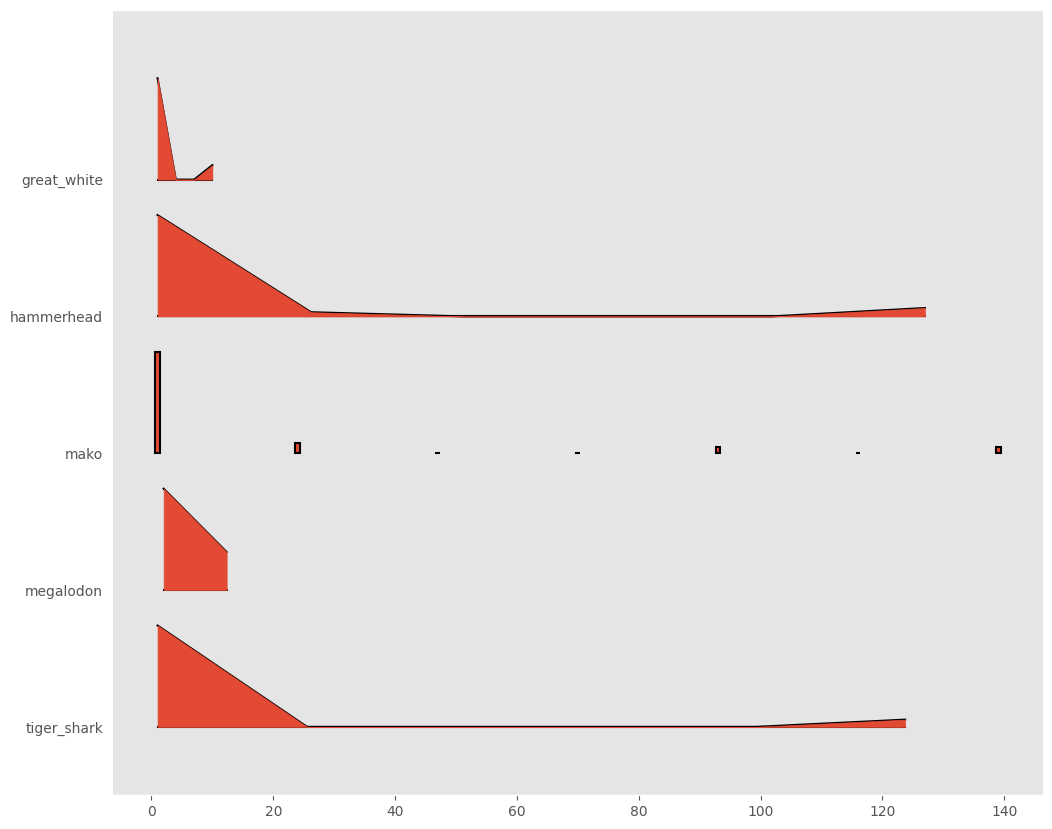

In [37]:
az.plot_forest(outs_len, kind='ridgeplot', hdi_prob=1);

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

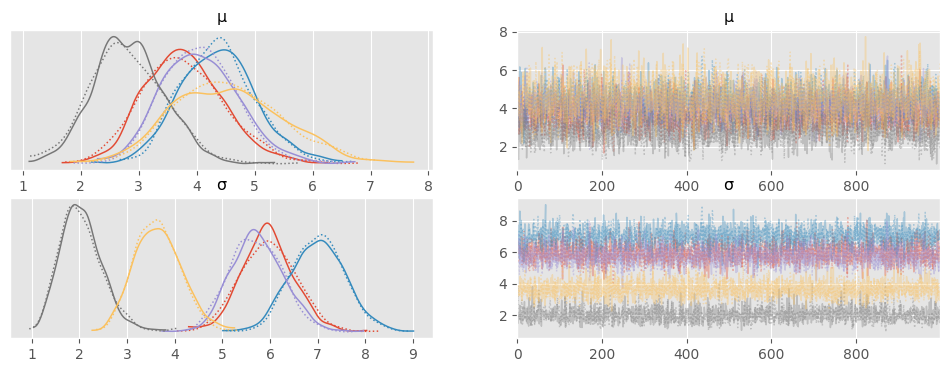

In [69]:
with pm.Model() as comparing_groups:
    μ = pm.HalfNormal('μ', sigma=5, shape=groups)
    σ = pm.HalfNormal('σ', sigma=1, shape=groups)

    y = pm.Gamma('y', mu=μ[idx], sigma=σ[idx], observed=outs)

    idata_cg = pm.sample()

az.plot_trace(idata_cg)